In [ ]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git
# import os
# os.chdir('S1_netpyne/info')

In [1]:
import matplotlib
import os
os.chdir('../sim')

In [2]:
# !nrnivmodl mod/

In [3]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 2.0*1e2 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = False

cfg.importCellMod = 'pkl' 
cfg.celldiversity = True 
cfg.poptypeNumber = 55
cfg.celltypeNumber = 207

In [4]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop
with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
	mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
for line in mtype_content.split('\n')[:-1]:
	metype, mtype, etype, n, m = line.split()
	cfg.cellNumber[metype] = int(n)
	cfg.popLabel[metype] = mtype
	cfg.popNumber[mtype] = int(m)

	if mtype not in popParam:
		popParam.append(mtype)
	cellParam.append(metype)

cfg.S1pops = popParam[0:55]
cfg.S1cells = cellParam[0:207]

#------------------------------------------------------------------------------  
cfg.popParamLabels = popParam[0:cfg.poptypeNumber] # to debug
cfg.cellParamLabels = cellParam[0:cfg.celltypeNumber] # to debug

In [5]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = False 

In [6]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		metype, mtype, etype, n, m = line.split()
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [7]:
subPopLabels = ['L5_SBC', 'L5_STPC']

for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:
        print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])        

L5_SBC_bNAC219 9 L5_SBC 25
L5_SBC_cACint209 9 L5_SBC 25
L5_SBC_dNAC222 7 L5_SBC 25
L5_STPC_cADpyr232 302 L5_STPC 302


In [8]:
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

In [9]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.popParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype (cfg.celldiversity = True)
	cfg.recordCells = []
	cellNumberLabel = 0 
	for metype in cfg.cellParamLabels:
		if metype in cfg.cellParamLabels:
			if cfg.cellNumber[metype] < 5:
				for numberME in range(cfg.cellNumber[metype]):
					cfg.recordCells.append((cfg.popLabel[metype],cellNumberLabel+numberME))
			else:
				for numberME in range(0,cfg.cellNumber[metype],int(cfg.cellNumber[metype]/4.5)):
					cfg.recordCells.append((cfg.popLabel[metype],cellNumberLabel+numberME))
			cellNumberLabel = cellNumberLabel + cfg.cellNumber[metype]
			if cellNumberLabel == cfg.popNumber[cfg.popLabel[metype]]:
				cellNumberLabel = 0 
                
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False			
cfg.recordTime = False  		
cfg.recordStep = 0.1    

In [10]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNets_test0'
cfg.saveFolder = '../info/test/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True	           	## Save json file
cfg.saveDataInclude = ['simConfig','simData'] ## , 'netParams', 'simConfig', 
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			
cfg.saveCellConns = True	

In [11]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 420.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [12]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	


cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


In [13]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)(M1: 2.0 ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)(M1: 500.0um/ms)
netParams.scaleConnWeight = 0.001 # weight conversion factor (from nS to uS)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [14]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
## S1
cfg.scaleDensity = 1.0

for popName in cfg.S1pops:
	layernumber = popName[1:2]
	if layernumber == '2':
		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}
	else:
		netParams.popParams[popName] = {'cellType': popName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.popNumber[popName])), 'diversity': True}

In [15]:
## S1 cell property rules
cellnumber = 0    
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    popName = cfg.popLabel[cellName]
    cellFraction = 1.0*cfg.cellNumber[cellName]/(morphoNumbers*cfg.popNumber[popName])
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cellName + '_' + str(morphoNumber+1)
        ## Load cell rules previously saved using netpyne format
        if cfg.importCellMod == 'pkl':
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.pkl')    
            netParams.renameCellParamsSec(label = cellMe, oldSec = 'soma_0', newSec = 'soma')

        cellRule = {'conds': {'cellType': popName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
        cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
        cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
        cellRule['conds']['cellType'] = popName
        cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
        cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']                 
        cellRule['secLists']['all'][0] = 'soma' # replace 'soma_0'
        cellRule['secLists']['somatic'][0]  = 'soma' # replace 'soma_0'
                              
        cellRule['secLists']['spiny'] = {}
        cellRule['secLists']['spinyEE'] = {}

        nonSpiny = ['axon_0', 'axon_1']
        cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
        nonSpinyEE = ['axon_0', 'axon_1', 'soma']
        cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']    
        #-----------------------------------------------------------------------------------#
        netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
        cellnumber=cellnumber+1

In [16]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA6'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 6.44, 'e': -80}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAA10'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 10.4, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 

ESynMech = ['AMPA', 'NMDA']
ISynMech = ['GABAA', 'GABAB']
ISynMech6 = ['GABAA6', 'GABAB']
ISynMech10 = ['GABAA10', 'GABAB']

In [17]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']
dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

In [18]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

if cfg.addConn:      
# I -> I
    for pre in Ipops:
        for post in Ipops:
            if float(connNumber[pre][post]) > 0:        

                if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
                    linear = 0
                    angular = 0
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
                elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                    linear = float(pmat[12.5][pre][post])
                    angular = 0
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                    d01 = int(float(d0[pre][post]))
                    y1 = float(pmat[25][pre][post])
                    y2 = float(pmat[d01][pre][post])
                    x1 = 25
                    x2 = d01                   
                    angular = (y2 - y1)/(x2 - x1)
                    linear = y2 - x2*angular
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                
                if decay[pre][post] > 10.0:
                    synMechType =  ISynMech10
                elif decay[pre][post] < 7.0:
                    synMechType =  ISynMech6
                else:
                    synMechType =  ISynMech

                netParams.connParams['II_'+pre+'_'+post] = { 
                    'preConds': {'pop': pre}, 
                    'postConds': {'pop': post},
                    'synMech': synMechType,
                    'probability': prob,
                    'weight': gsyn[pre][post] * cfg.IIGain, 
                    'synMechWeightFactor': cfg.synWeightFractionII,
                    'delay': 'defaultDelay+dist_3D/propVelocity',
                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                    'sec': 'spiny'}       

## I -> E
    for pre in Ipops:
        for post in Epops:
            if float(connNumber[pre][post]) > 0:        

                if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
                    linear = 0
                    angular = 0
                    prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
                elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                    linear = float(pmat[12.5][pre][post])
                    angular = 0
                    prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f*dist_2D+%f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                    d01 = int(float(d0[pre][post]))
                    y1 = float(pmat[25][pre][post])
                    y2 = float(pmat[d01][pre][post])
                    x1 = 25
                    x2 = d01                   
                    angular = (y2 - y1)/(x2 - x1)
                    linear = y2 - x2*angular
                    prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)

                if decay[pre][post] > 10.0:
                    synMechType =  ISynMech10
                elif decay[pre][post] < 7.0:
                    synMechType =  ISynMech6
                else:
                    synMechType =  ISynMech

                netParams.connParams['IE_'+pre+'_'+post] = { 
                    'preConds': {'pop': pre}, 
                    'postConds': {'pop': post},
                    'synMech': synMechType,
                    'probability': prob,
                    'weight': gsyn[pre][post] * cfg.IEGain, 
                    'synMechWeightFactor': cfg.synWeightFractionIE,
                    'delay': 'defaultDelay+dist_3D/propVelocity',
                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                    'sec': 'spiny'}     
#------------------------------------------------------------------------------   
## E -> E
    for pre in Epops:
        for post in Epops:
            if float(connNumber[pre][post]) > 0:        

                if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
                    linear = 0
                    angular = 0
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
                elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                    linear = float(pmat[12.5][pre][post])
                    angular = 0
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                    d01 = int(float(d0[pre][post]))
                    y1 = float(pmat[25][pre][post])
                    y2 = float(pmat[d01][pre][post])
                    x1 = 25
                    x2 = d01                   
                    angular = (y2 - y1)/(x2 - x1)
                    linear = y2 - x2*angular
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)

                netParams.connParams['EE_'+pre+'_'+post] = { 
                    'preConds': {'pop': pre}, 
                    'postConds': {'pop': post},
                    'synMech': ESynMech,
                    'probability': prob, 
                    'weight': gsyn[pre][post] * cfg.EEGain, 
                    'synMechWeightFactor': cfg.synWeightFractionEE,
                    'delay': 'defaultDelay+dist_3D/propVelocity',
                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                    'sec': 'spinyEE'}    
# ## E -> I
    for pre in Epops:
        for post in Ipops:
            if float(connNumber[pre][post]) > 0:        

                if int(float(d0[pre][post])) < 25:    #d0==12.5 -> single exponential fit
                    linear = 0
                    angular = 0
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])                     
                elif int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                    linear = float(pmat[12.5][pre][post])
                    angular = 0
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                    d01 = int(float(d0[pre][post]))
                    y1 = float(pmat[25][pre][post])
                    y2 = float(pmat[d01][pre][post])
                    x1 = 25
                    x2 = d01                   
                    angular = (y2 - y1)/(x2 - x1)
                    linear = y2 - x2*angular
                    prob = '%s * exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)

                netParams.connParams['EI_'+pre+'_'+post] = { 
                    'preConds': {'pop': pre}, 
                    'postConds': {'pop': post},
                    'synMech': ESynMech,
                    'probability': prob, 
                    'weight': gsyn[pre][post] * cfg.EIGain, 
                    'synMechWeightFactor': cfg.synWeightFractionEI,
                    'delay': 'defaultDelay+dist_3D/propVelocity',
                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                    'sec': 'spiny'}    
                   

In [19]:
for connpath in netParams.connParams.keys():
    print(connpath)
    print(netParams.connParams[connpath])
    print()

II_L5_SBC_L5_SBC
{'preConds': {'pop': 'L5_SBC'}, 'postConds': {'pop': 'L5_SBC'}, 'synMech': ['GABAA', 'GABAB'], 'probability': '0.09594 * exp(-dist_2D/46.51)*(dist_2D<200.0) if dist_2D > 50.0 else 0.000343 * dist_2D + 0.015310', 'weight': 0.83, 'synMechWeightFactor': [1.0, 1.0], 'delay': 'defaultDelay+dist_3D/propVelocity', 'synsPerConn': 16, 'sec': 'spiny'}

IE_L5_SBC_L5_STPC
{'preConds': {'pop': 'L5_SBC'}, 'postConds': {'pop': 'L5_STPC'}, 'synMech': ['GABAA', 'GABAB'], 'probability': '0.24710*exp(-dist_2D/48.18)*(dist_2D<250.0) if dist_2D > 100.0 else -0.000383 * dist_2D + 0.068273', 'weight': 0.91, 'synMechWeightFactor': [1.0, 1.0], 'delay': 'defaultDelay+dist_3D/propVelocity', 'synsPerConn': 27, 'sec': 'spiny'}

EE_L5_STPC_L5_STPC
{'preConds': {'pop': 'L5_STPC'}, 'postConds': {'pop': 'L5_STPC'}, 'synMech': ['AMPA', 'NMDA'], 'probability': '0.15542 * exp(-dist_2D/79.63)*(dist_2D<375.0) if dist_2D > 50.0 else -0.000324 * dist_2D + 0.096310', 'weight': 0.8, 'synMechWeightFactor': [1.0

In [20]:
#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 6.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': post}, 
                'ynorm':[0,1], 
                'sec': 'spinyEE', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimE[post],
                'delay': 0.1, 
                'synMech': 'AMPA'}

    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': post}, 
                'ynorm':[0,1], 
                'sec': 'spiny', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimE[post],
                'delay': 0.1, 
                'synMech': 'AMPA'}

    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': post}, 
                'ynorm':[0,1], 
                'sec': 'spiny', 
                'loc': 0.5, 
                'synMechWeightFactor': [1.0],
                'weight': GsynStimI[post],
                'delay': 0.1, 
                'synMech': 'GABAA'}

In [21]:
for stimpath in netParams.stimSourceParams.keys():
    print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

StimSynS1_S_all_INH->L5_SBC_0
StimSynS1_S_all_INH->L5_SBC_1
StimSynS1_S_all_INH->L5_SBC_2
StimSynS1_S_all_INH->L5_SBC_3
StimSynS1_S_all_INH->L5_SBC_4
StimSynS1_S_all_EXC->L5_SBC_0
StimSynS1_S_all_EXC->L5_SBC_1
StimSynS1_S_all_EXC->L5_SBC_2
StimSynS1_S_all_EXC->L5_SBC_3
StimSynS1_S_all_EXC->L5_SBC_4
StimSynS1_S_all_INH->L5_STPC_0
StimSynS1_S_all_INH->L5_STPC_1
StimSynS1_S_all_INH->L5_STPC_2
StimSynS1_S_all_INH->L5_STPC_3
StimSynS1_S_all_INH->L5_STPC_4
StimSynS1_S_all_EXC->L5_STPC_0
StimSynS1_S_all_EXC->L5_STPC_1
StimSynS1_S_all_EXC->L5_STPC_2
StimSynS1_S_all_EXC->L5_STPC_3
StimSynS1_S_all_EXC->L5_STPC_4


In [22]:
for stimpath in netParams.stimTargetParams.keys():
    print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

StimSynS1_T_all_EXC->L5_STPC_0
StimSynS1_T_all_EXC->L5_STPC_1
StimSynS1_T_all_EXC->L5_STPC_2
StimSynS1_T_all_EXC->L5_STPC_3
StimSynS1_T_all_EXC->L5_STPC_4
StimSynS1_T_all_EXC->L5_SBC_0
StimSynS1_T_all_EXC->L5_SBC_1
StimSynS1_T_all_EXC->L5_SBC_2
StimSynS1_T_all_EXC->L5_SBC_3
StimSynS1_T_all_EXC->L5_SBC_4
StimSynS1_T_all_INH->L5_STPC_0
StimSynS1_T_all_INH->L5_STPC_1
StimSynS1_T_all_INH->L5_STPC_2
StimSynS1_T_all_INH->L5_STPC_3
StimSynS1_T_all_INH->L5_STPC_4
StimSynS1_T_all_INH->L5_SBC_0
StimSynS1_T_all_INH->L5_SBC_1
StimSynS1_T_all_INH->L5_SBC_2
StimSynS1_T_all_INH->L5_SBC_3
StimSynS1_T_all_INH->L5_SBC_4


## Run small Nets in a sigle job

In [23]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  


Start time:  2021-07-03 00:32:11.822924

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 327 
  Done; cell creation time = 10.95 s.
Making connections...
  Number of connections on node 0: 2394 
  Number of synaptic contacts on node 0: 29280 
  Done; cell connection time = 3.18 s.
Adding stims...
  Number of stims on node 0: 3270 
  Done; cell stims creation time = 0.66 s.
Recording 327 traces of 1 types on node 0
0.0s

Running simulation for 200.0 ms...
0.1s
0.2s
  Done; run time = 447.84 s; real-time ratio: 0.00.

Gathering data...
  Done; gather time = 0.69 s.

Analyzing...
  Cells: 327
  Connections: 2721 (8.32 per cell)
  Synaptic contacts: 32550 (99.54 per cell)
  Spikes: 282 (4.31 Hz)
  Simulated time: 0.2 s; 1 workers
  Run time: 447.84 s
   L5_SBC : 22.000 Hz
   L5_STPC : 2.848 Hz
Saving output as ../info/test/subNets_test0/subNets_test0.json  ... 
Finished saving!
  Done; saving time = 0.73 s.
  Done; plotting time = 0.00 s

Total time = 464

## Net infos

Plotting connectivity matrix...


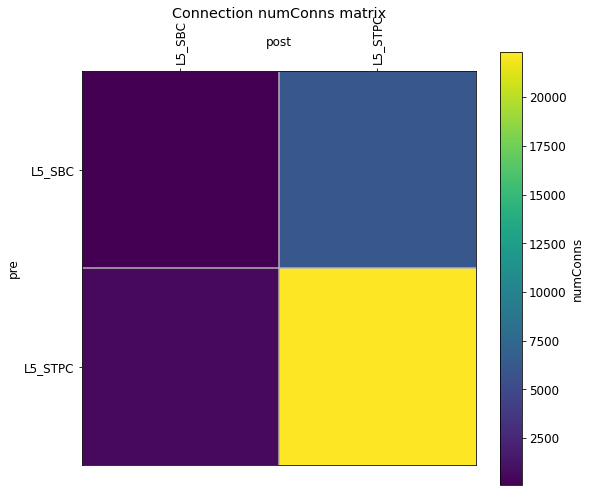

In [24]:
# features = ['numConns','convergence']
test = sim.analysis.plotConn(includePre=subPopLabels, includePost = subPopLabels, feature='numConns', showFig=False);

In [25]:
test[1]['connMatrix']

array([[   96.,  6156.],
       [  688., 22340.]])

In [26]:
connNumber = connData['connNumber']
synperconnNumber = connData['synperconnNumber']

i=0
for pre in subPopLabels:
    j=0
    for post in subPopLabels:
        synperconn = int(synperconnNumber[pre][post]+0.5)        
        print('%s->%s \n   MCs_BBP=%.0f   NetPyNE=%.0f' % (pre,post,2*synperconn*float(connNumber[pre][post]),test[1]['connMatrix'][i][j]))
        j+=1
    i+=1

L5_SBC->L5_SBC 
   MCs_BBP=115   NetPyNE=96
L5_SBC->L5_STPC 
   MCs_BBP=4752   NetPyNE=6156
L5_STPC->L5_SBC 
   MCs_BBP=630   NetPyNE=688
L5_STPC->L5_STPC 
   MCs_BBP=21276   NetPyNE=22340


Plotting 2D representation of network cell locations and connections...


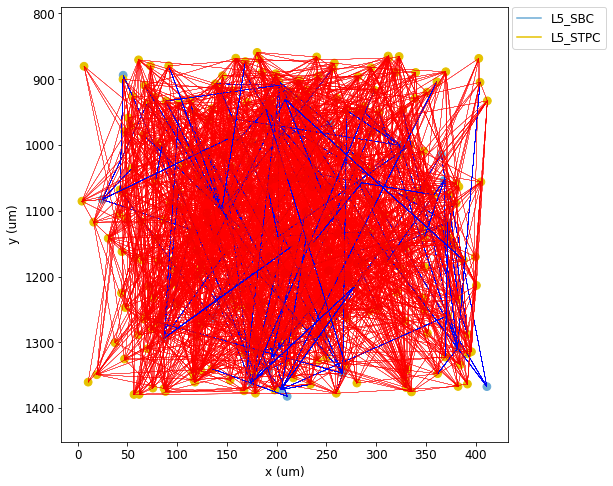

In [27]:
sim.analysis.plot2Dnet(include=subPopLabels,view='xy', showConns=True, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


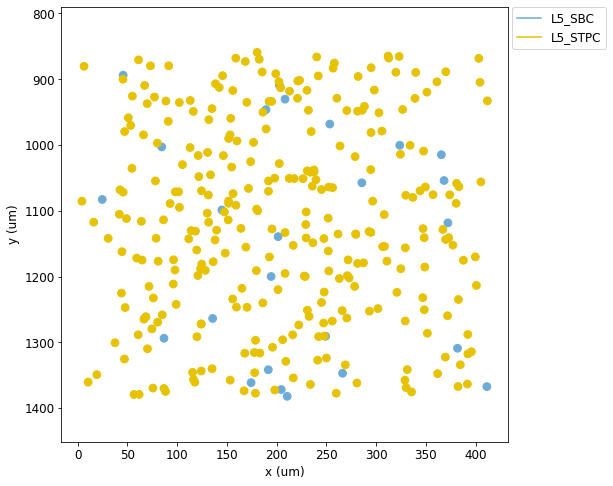

Plotting 2D representation of network cell locations and connections...


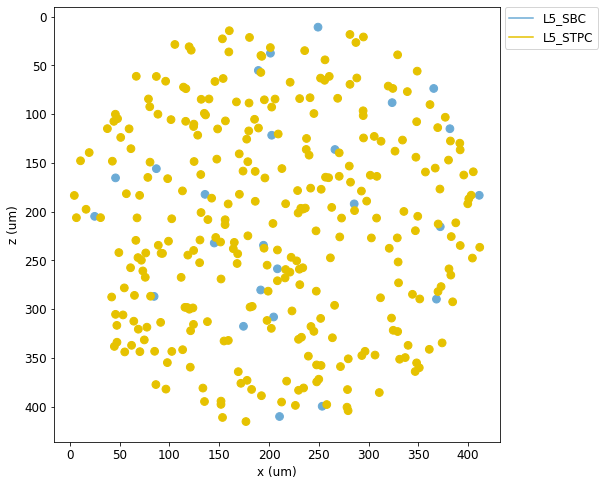

In [28]:
sim.analysis.plot2Dnet(include=subPopLabels,view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=subPopLabels,view='xz', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

## Raster and traces

Plotting raster...


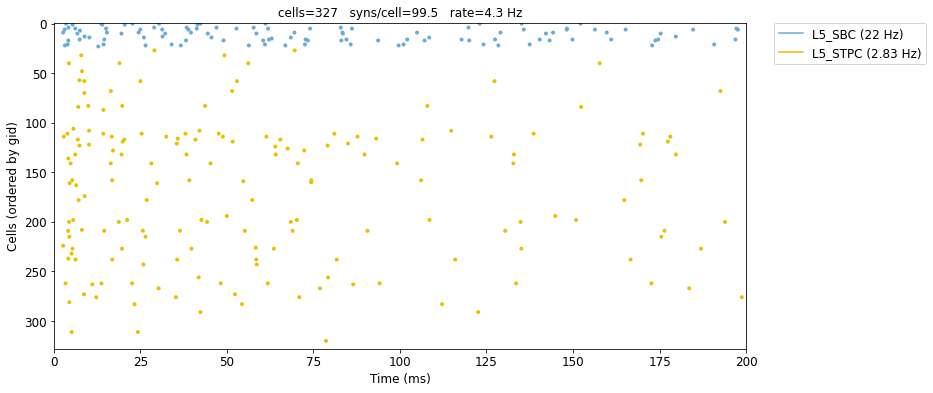

In [29]:
sim.analysis.plotRaster(include=subPopLabels, timeRange=[0,cfg.duration], orderBy='gid', orderInverse=True, labels='legend', popRates=True, lw=2, marker='.', markerSize=16, figSize=(15, 6), fontSize=12, dpi=300, saveFig=True, showFig=False);

In [30]:
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:
        print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     

L5_SBC_bNAC219 9 L5_SBC 25
L5_SBC_cACint209 9 L5_SBC 25
L5_SBC_dNAC222 7 L5_SBC 25
L5_STPC_cADpyr232 302 L5_STPC 302


In [45]:
traces = [(mtype, [i for i in range(0,cfg.popNumber[mtype],int(cfg.popNumber[mtype]/4.5))]) for mtype in subPopLabels]
traces

[('L5_SBC', [0, 5, 10, 15, 20]), ('L5_STPC', [0, 67, 134, 201, 268])]

Plotting recorded cell traces ... trace


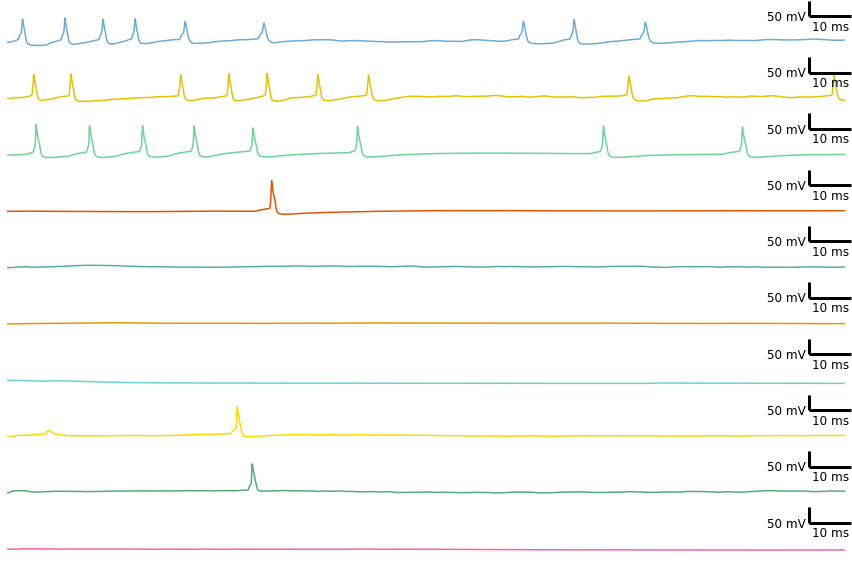

In [46]:
sim.analysis.plotTraces(include=traces, timeRange=[0,cfg.duration], overlay=False, oneFigPer='trace', ylim=[-90,50], subtitles= False, axis=False, scaleBarLoc=1, figSize=(12, 8), fontSize=12, saveFig=True);

In [41]:
subPopLabels

['L5_SBC', 'L5_STPC']

Plotting recorded cell traces ... trace


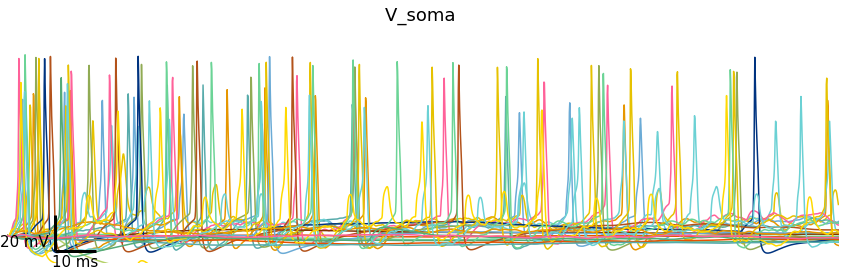

Plotting recorded cell traces ... trace


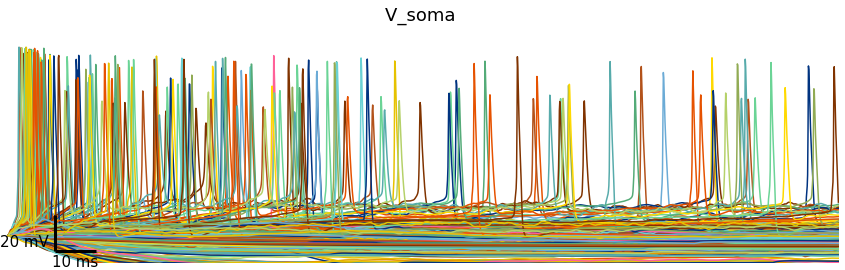

In [40]:
for pops in subPopLabels:
    sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', ylim=[-80,50], axis=False, scaleBarLoc=3, figSize=(12, 4), fontSize=15, saveFig='../info/test/'+cfg.simLabel+'/'+cfg.simLabel +'_'+pops+ '_Vt.png');